In [1]:
import sys
sys.path.append("../src/python")

import os.path as path
import logging
from tqdm import tqdm

# data loading
import pandas as pd
import numpy as np

import torch
import torch.distributions as dist
import zuko

import matplotlib.pyplot as plt

from weathergen.utils import fourier_lsq, fourier_feats
from weathergen.data import EOBSBasinDataset

gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")

DATA_DIR = "/data/compoundx/causal_flood/basins_averaged"

In [2]:
def torch_precip_summary_stats(pr, axis=0, thresh=0.0):
    pmean = torch.mean(pr, axis=axis)
    p99 = torch.nanquantile(torch.where(pr > thresh, pr, torch.nan), 0.99, axis=axis)
    intensity = torch.nanmean(torch.where(pr > thresh, pr, torch.nan), axis=axis)
    wetdays = torch.sum(pr > thresh, axis=axis)
    pdd = ((pr[1:] <= thresh)*(pr[:-1] <= thresh)).sum(axis=axis) / pr.shape[axis]
    pwd = ((pr[1:] > thresh)*(pr[:-1] <= thresh)).sum(axis=axis) / pr.shape[axis]
    # cdd = cumulative_dry_days(pr, threshold=cdd_thresh, axis=axis)
    return torch.stack([pmean, p99, intensity, wetdays, pdd, pwd])

def precip_summary_stats(df):
    T = df.tavg.values
    stats = torch_precip_summary_stats(torch.from_numpy(T))
    return pd.DataFrame(stats.numpy().reshape((1,-1)), columns=["pmean","p99","intensity","wetdays","pdd","pwd"])

def torch_tavg_summary_stats(Tair):
    Tair90 = torch.quantile(Tair, 0.99, axis=0, keepdim=True)
    Tair50 = torch.quantile(Tair, 0.50, axis=0, keepdim=True)
    Tair10 = torch.quantile(Tair, 0.01, axis=0, keepdim=True)
    tdd = torch.sum(torch.where(Tair > 0, Tair, 0), axis=0, keepdim=True)
    fdd = torch.sum(torch.where(Tair <= 0, Tair, 0), axis=0, keepdim=True)
    return torch.cat([Tair10, Tair50, Tair90, tdd, fdd])

def tavg_summary_stats(df):
    T = df.tavg.values
    stats = torch_tavg_summary_stats(torch.from_numpy(T))
    return pd.DataFrame(stats.numpy().reshape((1,-1)), columns=["T10","T50","T90","TDD","FDD"])

In [3]:
basins = []
basin_info = pd.read_csv(path.join(DATA_DIR, "basins_info.csv"))
basin_info = basin_info.loc[basin_info.country == "DE"]
dataset = EOBSBasinDataset(basin_info, path.join(DATA_DIR, "observational"), summarizer=tavg_summary_stats)

loading basin data: 100%|██████████| 236/236 [01:28<00:00,  2.67it/s]


In [4]:
basin_idx = 0
all_basins = dataset.dataset
all_basins.loc[all_basins.id == all_basins.id.unique()[basin_idx]]
all_basins["time"] = pd.to_datetime(all_basins["time"])

In [5]:
all_basins_ref = all_basins[all_basins.time.between("1950","2000")]
n_harmonics = 180
f0 = 1/365.25 # fundamental frequency
freqs = np.arange(0,n_harmonics)*f0
# features_ref = all_basins_ref.tavg.groupby([all_basins_ref.id, all_basins_ref.time.dt.year]).apply(
#     lambda x: pd.DataFrame(fourier_lsq(np.arange(0,x.shape[0]), x.values, freqs)[0].reshape((1,-1)))
# ).reset_index().set_index('time')
# features_mean = features_ref.mean(axis=0)
# features_scale = features_ref.std(axis=0)
# summary_stats = all_basins_ref.tavg.groupby([all_basins_ref.id, all_basins_ref.time.dt.year]).apply(
#     lambda x: pd.DataFrame(tair_summary_stats(x.values).reshape((1,-1)), columns=['T10','T50','T90','TDD','FDD'])
# ).reset_index().drop(columns=["level_2"], axis=1).set_index('time')

In [6]:
# # plot first year for demonstration
# Tavg_1950 = basin_data_ref.tavg[basin_data_ref.index.year == 1950]
# ff_1950 = np.array(fourier_feats(np.arange(0, Tavg_1950.shape[0]), freqs))
# plt.plot(Tavg_1950, label="Observed")
# plt.plot(Tavg_1950.index, np.matmul(ff_1950, features_ref.iloc[0:1, :].values.T)[:,0], alpha=0.5, label="Fourier approx.")
# plt.legend()
# plt.show()

In [7]:
# X_mean = torch.tensor(features_mean.values)
# X_scale = torch.tensor(features_scale.values)
# X = (torch.tensor(features_ref.values) - X_mean) / X_scale
# C = torch.tensor(summary_stats.values)
# C_mean = C.mean(axis=0)
# C_scale = C.std(axis=0)
# C_std = (C - C_mean) / C_scale
# B = torch.nested.nested_tensor([torch.tensor(np.array(fourier_feats(np.arange(0,g.shape[0]), freqs))) for i,g in basin_data_ref.tavg.groupby(basin_data_ref.index.year)])
# assert X.shape[0] == C_std.shape[0]

In [8]:
transforms = 4
components = 1
context_dims = len(dataset.basin_features) + dataset.summary_stats.shape[1]-2
flow = zuko.flows.GF(365, context_dims, transforms=transforms, components=components).to(device)
run_info = torch.load(f"../data/models/basin_flow_DE_transforms={transforms}_components={components}.pt", map_location=torch.device('cpu'))
flow.load_state_dict(run_info["state"])
print(list(run_info["error"].values())[-1])

{'nll': tensor(-168.1231, requires_grad=True), 'stats': tensor(1.5999)}


/tmp/ipykernel_3669030/2524594496.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  run_info = torch.load(f"../data/models/basin_flow_DE_transforms={transforms}_components

In [9]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
y_standardizer = dataset.standardizer["data"]
stats_standardizer = dataset.standardizer["stats"]
y_shift = torch.from_numpy(y_standardizer["shift"][["tavg"]].values.astype(np.float32)).to(device)
y_scale = torch.from_numpy(y_standardizer["scale"][["tavg"]].values.astype(np.float32)).to(device)
s_shift = torch.from_numpy(stats_standardizer["shift"].values.astype(np.float32)).to(device)
s_scale = torch.from_numpy(stats_standardizer["scale"].values.astype(np.float32)).to(device)

In [ ]:
prog = tqdm(range(len(dataset)), desc="Train")
for i in prog:
    # load data for basin i
    feats_i, data_i, stats_i = dataset[i]
    year_inds = data_i.groupby(data_i.time.dt.year).indices
    x_i = torch.from_numpy(dataset.standardize(feats_i, "features").values.astype(np.float32).reshape((1,-1))).to(device)
    y_i = torch.from_numpy(dataset.standardize(data_i.iloc[:,1:], "data")[["tavg"]].values.astype(np.float32)).to(device)
    s_i = torch.from_numpy(dataset.standardize(stats_i, "stats").values.astype(np.float32)).to(device)
    c_i = torch.concat([x_i*torch.ones((s_i.shape[0],1)).to(device), s_i], axis=1)
    torch._assert(~torch.isnan(x_i).any(), "NaN detected in x_i")
    torch._assert(~torch.isnan(y_i).any(), "NaN detected in y_i")
    torch._assert(~torch.isnan(s_i).any(), "NaN detected in s_i")
    y_i_years = [y_i[idx,:][:365,:].T for idx in year_inds.values()]
    y_ij = torch.concat(y_i_years, axis=0)
    assert y_ij.shape[0] == c_i.shape[0] == s_i.shape[0]
    cond_flow = flow(c_i)
    nll = -cond_flow.log_prob(y_ij).mean()
    y_sim = cond_flow.sample()*y_scale.reshape((1,-1)) + y_shift.reshape((1,-1))
    s_sim = torch_tavg_summary_stats(y_sim.T)
    s_sim_std = (s_sim - s_shift.reshape((-1,1)))/s_scale.reshape((-1,1))
    s_err = torch.mean((s_sim_std.T - s_i)**2)
    loss = nll + s_err
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    prog.set_postfix(loss=loss.cpu().detach().numpy())

Train: 100%|██████████| 229/229 [06:35<00:00,  1.73s/it, loss=151.47398] 


In [22]:
feats_0, data_0, stats_0 = dataset[0]
year_inds0 = data_0.groupby(data_0.time.dt.year).indices
x0 = torch.from_numpy(dataset.standardize(feats_0, "features").values.astype(np.float32).reshape((1,-1))).to(device)
y0 = torch.from_numpy(dataset.standardize(data_0.iloc[:,1:], "data")[["tavg"]].values.astype(np.float32)).to(device)
s0 = torch.from_numpy(dataset.standardize(stats_0, "stats").values.astype(np.float32)).to(device)
c0 = torch.concat([x0*torch.ones((s0.shape[0],1)).to(device), s0], axis=1)
cond_flow = flow(c0)
y_sim = cond_flow.sample()*y_scale.reshape((1,-1)) + y_shift.reshape((1,-1))
y_sim_stats = torch_tavg_summary_stats(y_sim.T)
y_sim.shape

torch.Size([72, 365])

In [23]:
stats_err = y_sim_stats.T.numpy() - stats_0
stats_err.mean(axis=0)

T10     0.369969
T50     0.196637
T90    -0.170249
TDD    52.728377
FDD     3.579231
dtype: float64

In [24]:
c0.shape

torch.Size([72, 11])

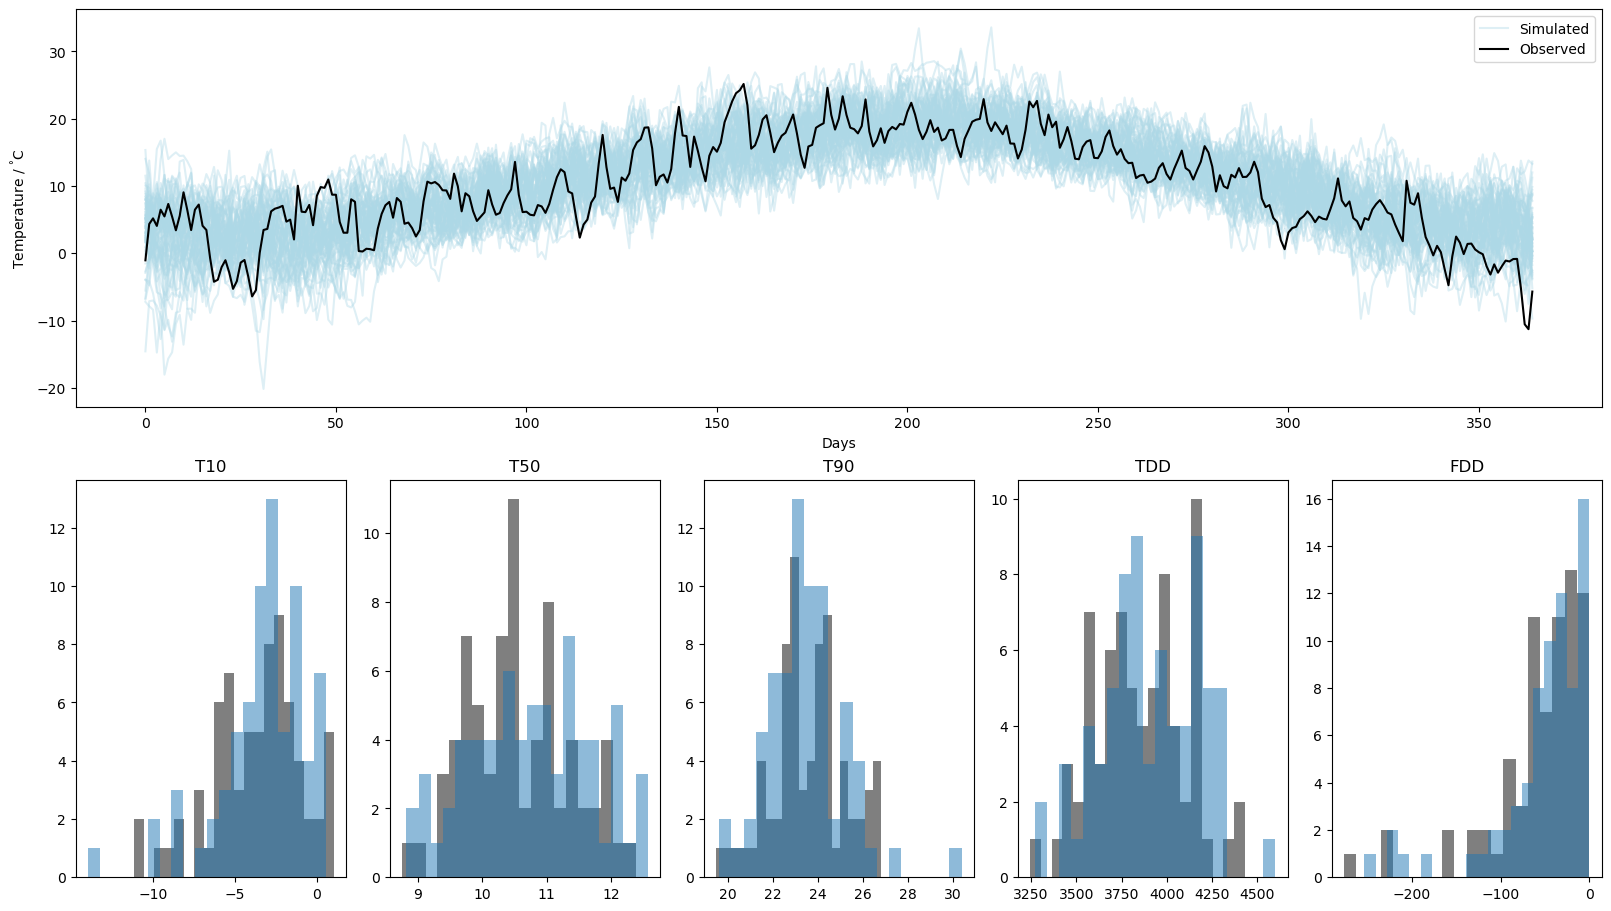

In [25]:
idx = 0
axd = plt.figure(figsize=(16,9),layout="constrained").subplot_mosaic(
    """
    AAAAA
    BCDEF
    """
)
plt_sims = axd["A"].plot(y_sim.numpy().T, alpha=0.4, c="lightblue");
plt_obs = axd["A"].plot(data_0.iloc[list(year_inds0.values())[idx]].tavg.values, color="black");
axd["A"].legend(handles=[plt_sims[0], plt_obs[0]], labels=["Simulated", "Observed"])
axd["A"].set_xlabel("Days")
axd["A"].set_ylabel("Temperature / $^{\\degree}$C")
for i,k in enumerate(["B","C","D","E","F"]):
    axd[k].hist(stats_0.iloc[:,i].values, color='black', alpha=0.5, bins=20)
    axd[k].hist(y_sim_stats.numpy()[i,:], alpha=0.5, bins=20);
    axd[k].set_title(stats_0.columns[i])
plt.savefig(f"../plots/wxflow_temperature_basin={basin_info.iloc[idx].id}_sims_vs_obs.png")

In [27]:
feats_0, data_0, stats_0 = dataset[0]
year_inds0 = data_0.groupby(data_0.time.dt.year).indices
x0 = torch.from_numpy(dataset.standardize(feats_0, "features").values.astype(np.float32).reshape((1,-1))).to(device)
y0 = torch.from_numpy(dataset.standardize(data_0.iloc[:,1:], "data")[["tavg"]].values.astype(np.float32)).to(device)
s0 = torch.from_numpy(dataset.standardize(stats_0, "stats").values.astype(np.float32)).to(device)
s0 += 1.0
c0 = torch.concat([x0*torch.ones((s0.shape[0],1)).to(device), s0], axis=1)
cond_flow = flow(c0)
y_sim = cond_flow.sample()*y_scale.reshape((1,-1)) + y_shift.reshape((1,-1))
y_sim_stats = torch_tavg_summary_stats(y_sim.T)
y_sim.shape

torch.Size([72, 365])

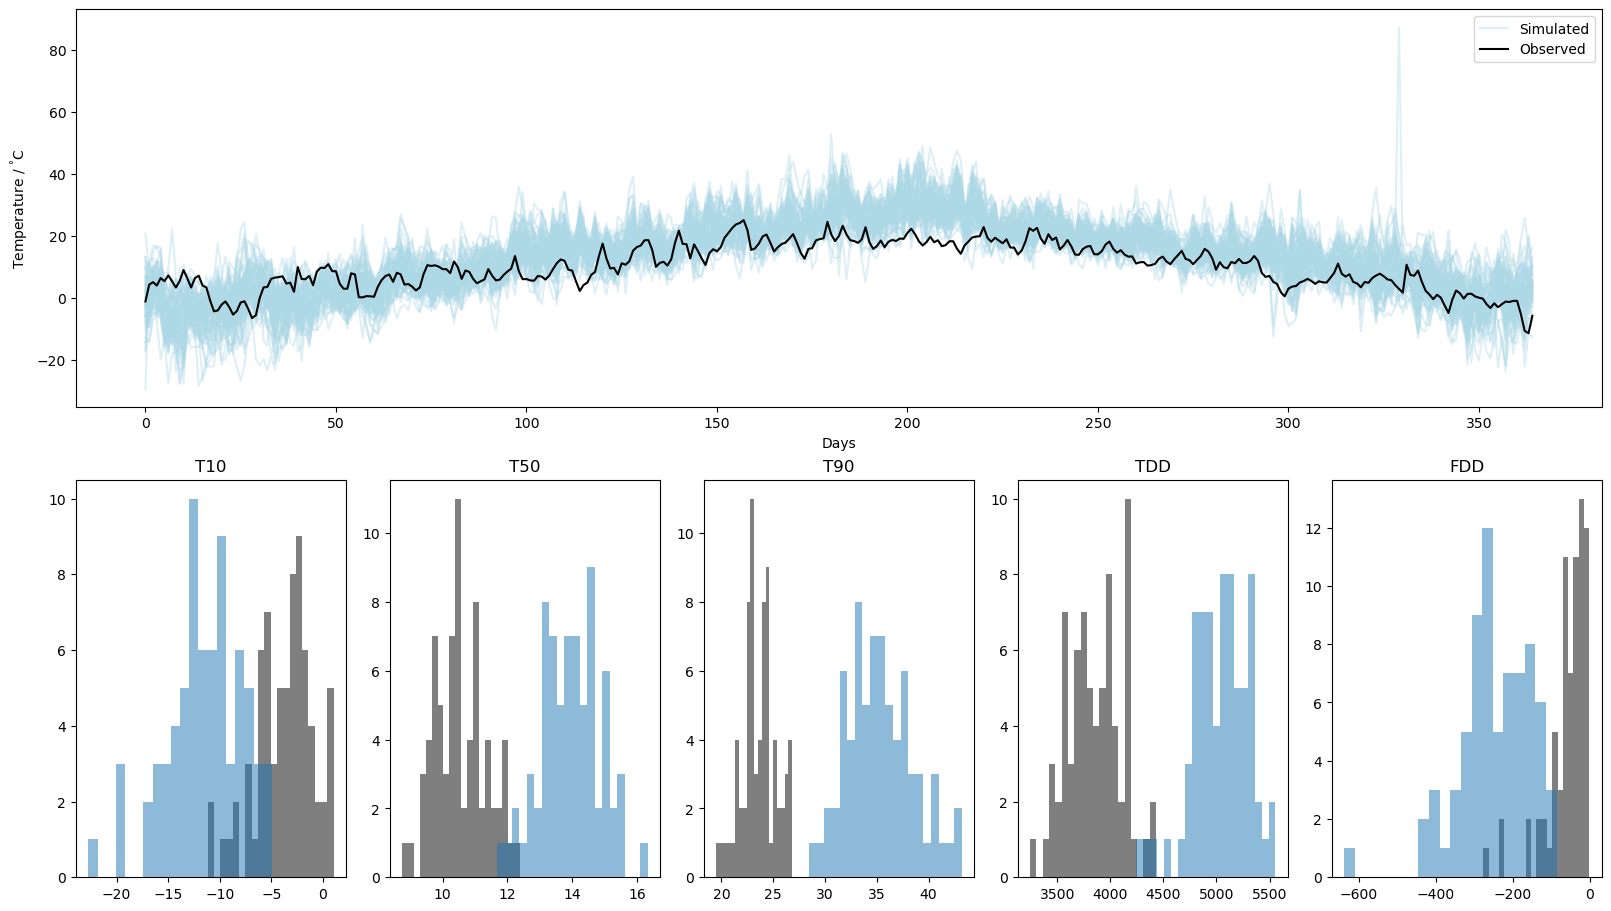

In [28]:
idx = 0
axd = plt.figure(figsize=(16,9),layout="constrained").subplot_mosaic(
    """
    AAAAA
    BCDEF
    """
)
plt_sims = axd["A"].plot(y_sim.numpy().T, alpha=0.4, c="lightblue");
plt_obs = axd["A"].plot(data_0.iloc[list(year_inds0.values())[idx]].tavg.values, color="black");
axd["A"].legend(handles=[plt_sims[0], plt_obs[0]], labels=["Simulated", "Observed"])
axd["A"].set_xlabel("Days")
axd["A"].set_ylabel("Temperature / $^{\\degree}$C")
for i,k in enumerate(["B","C","D","E","F"]):
    axd[k].hist(stats_0.iloc[:,i].values, color='black', alpha=0.5, bins=20)
    axd[k].hist(y_sim_stats.numpy()[i,:], alpha=0.5, bins=20);
    axd[k].set_title(stats_0.columns[i])
plt.savefig(f"../plots/wxflow_temperature_basin={basin_info.iloc[idx].id}_perturbed_sims_vs_obs.png")